In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from pathlib import Path

from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import torch.nn.functional as F
import torchmetrics

import jax
import jax.numpy as jnp
from jax import jit

from pytorch_lightning.strategies import DDPStrategy

from paper_utils import LightningResNet18

import configparser
from paper_utils import HenonMapPoincareDataModule

In [2]:
isBool = lambda x: x.lower() == "true"
converters = {'IntList': lambda x: [int(i.strip()) for i in x.strip(" [](){}").split(',')],
    'FloatList': lambda x: [float(i.strip()) for i in x.strip(" [](){}").split(',')],
    'BoolList': lambda x: [isBool(i.strip()) for i in x.strip(" [](){}").split(',')]}
config = configparser.ConfigParser(converters=converters)

In [3]:
config.read("./configs/model_training/henon_map_study.cfg")
# LOGGING params
# -------------------------------------------------------
log_dir = config.get('LOGGING', 'log_dir')
name = config.get('LOGGING', 'name')
# -------------------------------------------------------
# HARDWARE params  
# -------------------------------------------------------  
num_workers = config.getint('HARDWARE', 'num_workers')
auto_select_gpus = config.getboolean('HARDWARE', 'auto_select_gpus')
num_gpus = config.getint('HARDWARE', 'num_gpus')

if auto_select_gpus==True:
    devices = num_gpus
else:
    devices = config.getIntList("HARDWARE", "devices")
if devices > 1:
    num_workers = 0
    strategy = DDPStrategy(find_unused_parameters=False)
else:
    num_workers = num_workers
    strategy = None
# -------------------------------------------------------
# DATAMODULE params
# -------------------------------------------------------
randomize_flags = config.getBoolList('DATAMODULE', 'randomize')
if "num_train_samples" in config['DATAMODULE']:
    # setting total samples according to 80:20 train/test and train+val/test ratios
    num_sample_list = [int(num / .64) for num in config.getIntList('DATAMODULE', 'num_train_samples')]
    if "num_samples" in config['DATAMODULE']:
        print("WARNING: num_samples and num_train_samples both specified in config. num_samples will be ignored")
else:
    num_sample_list = config.getFloatList('DATAMODULE', 'num_samples')
batch_size = config.getint('DATAMODULE', 'batch_size')
img_widths = config.getIntList('DATAMODULE', 'img_width')
alpha = config.getfloat('DATAMODULE', 'alpha')
min_samples = config.getint('DATAMODULE', 'min_samples', fallback=0)
max_samples = config.getint('DATAMODULE', 'max_samples', fallback=-1)
min_traj_len = config.getint('DATAMODULE', 'min_traj_len')
max_traj_len = config.getint('DATAMODULE', 'max_traj_len')
num_params = config.getint('DATAMODULE', 'num_params')
a_range = config.getFloatList('DATAMODULE', 'a_range')
b_range = config.getFloatList('DATAMODULE', 'b_range')

coords = config.getIntList('DATAMODULE', 'coords', fallback=[0,1])
print(f"{coords=}")
x_range = config.getFloatList('DATAMODULE', 'x_range', fallback=None)
y_range = config.getFloatList('DATAMODULE', 'y_range', fallback=None)

coords=[0, 1]


In [4]:
trainer = pl.Trainer(
    logger=False,
    accelerator='gpu',
    devices=devices,
    num_sanity_val_steps=0,
    deterministic=True,
    auto_select_gpus=auto_select_gpus,
    enable_progress_bar=False
)

assert(len(img_widths) == 1)

np.random.seed(42)
torch.manual_seed(42)

aug_datamodule = HenonMapPoincareDataModule(
                    num_samples=3200,
                    batch_size=32, 
                    a_range=a_range,
                    b_range=b_range,
                    x_range=x_range,
                    y_range=y_range,
                    img_width=img_widths[0],
                    alpha=alpha,
                    min_samples=min_samples,
                    max_samples=max_samples,
                    min_traj_len=min_traj_len,
                    num_iters=max_traj_len,
                    num_workers=num_workers,
                    verbose=False,
                    randomize=True)

np.random.seed(42)
torch.manual_seed(42)
                    
non_aug_datamodule = HenonMapPoincareDataModule(
                num_samples=3200,
                batch_size=32, 
                a_range=a_range,
                b_range=b_range,
                x_range=x_range,
                y_range=y_range,
                img_width=img_widths[0],
                alpha=alpha,
                min_samples=min_samples,
                max_samples=max_samples,
                min_traj_len=min_traj_len,
                num_iters=max_traj_len,
                num_workers=num_workers,
                verbose=False,
                randomize=False)

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
df_list = []
p = Path(log_dir)
for i in p.rglob('*version_0/'):
    print(i.parent.name)
    hparam_dict = yaml.safe_load(open(i / 'hparams.yaml'))
    num_train = hparam_dict['num_train']
    randomized = hparam_dict['randomize']
    print(f"{num_train=}, {randomized=}")
    for child in i.parent.iterdir():
        if child.is_dir():
            for j in child.iterdir():
                if j.is_dir():
                    for model_ckpt in j.iterdir():
                        print(f"{model_ckpt.name=}")
                        model = LightningResNet18.load_from_checkpoint(model_ckpt.resolve())
                        datamodule = aug_datamodule if randomized else non_aug_datamodule
                        test_loss = trainer.test(model=model, dataloaders=datamodule.test_dataloader(), verbose=False)[0]["val_mse"]
                        df_list.append({"loss": test_loss, "num_train": num_train, "Train Augmentation": randomized})
henon_df = pd.DataFrame(df_list)

henon_map_num_samples_1600
num_train=1024, randomized=False
model_ckpt.name='epoch=705-val_mse=4.92e-01_randomized_False.ckpt'


/home/connorsteph/miniconda3/envs/DL_PSI_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=768-val_mse=4.29e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=548-val_mse=4.06e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_1600
num_train=1024, randomized=True
model_ckpt.name='epoch=751-val_mse=4.78e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=722-val_mse=5.50e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=768-val_mse=5.88e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_800
num_train=501, randomized=False
model_ckpt.name='epoch=1542-val_mse=6.78e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1163-val_mse=7.18e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1078-val_mse=8.41e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_800
num_train=501, randomized=True
model_ckpt.name='epoch=1554-val_mse=8.26e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1529-val_mse=7.23e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1331-val_mse=6.17e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_400
num_train=256, randomized=False
model_ckpt.name='epoch=2761-val_mse=8.42e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1697-val_mse=8.68e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2758-val_mse=1.18e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_400
num_train=256, randomized=True
model_ckpt.name='epoch=1782-val_mse=9.19e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=3062-val_mse=9.43e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2580-val_mse=9.83e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_12800
num_train=8172, randomized=False
model_ckpt.name='epoch=92-val_mse=1.44e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=73-val_mse=1.79e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=95-val_mse=2.11e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_12800
num_train=8172, randomized=True
model_ckpt.name='epoch=94-val_mse=5.20e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=94-val_mse=6.05e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=63-val_mse=5.82e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_3200
num_train=2079, randomized=False
model_ckpt.name='epoch=256-val_mse=8.36e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=276-val_mse=1.33e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=322-val_mse=1.12e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_3200
num_train=2079, randomized=True
model_ckpt.name='epoch=374-val_mse=4.44e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=362-val_mse=4.29e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=339-val_mse=4.03e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_6400
num_train=4096, randomized=False
model_ckpt.name='epoch=189-val_mse=2.75e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=176-val_mse=3.57e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=164-val_mse=3.28e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_6400
num_train=4096, randomized=True
model_ckpt.name='epoch=188-val_mse=5.22e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=169-val_mse=5.38e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=181-val_mse=4.41e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_200
num_train=125, randomized=False
model_ckpt.name='epoch=3531-val_mse=2.23e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1316-val_mse=2.46e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=3806-val_mse=2.48e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_200
num_train=125, randomized=True
model_ckpt.name='epoch=4861-val_mse=1.42e-01_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=4112-val_mse=1.64e-01_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=5533-val_mse=1.76e-01_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


In [6]:
import seaborn as sns

LINE_PLOT_BLACK = ".2"
BAR_PLOT_ORANGE = (0.34705882352941175, 0.4588235294117645, 0.6411764705882353, 1.0)
LINE_PLOT_ORANGE = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
HATCH = "/"

sns.set_theme(context="paper", style="ticks", font_scale=1.75)

# update line plot markers
def fix_lineplot_markers(plot):
    for line in plot.get_lines():
        if line.get_color() == LINE_PLOT_BLACK:
            line.set_marker('')
        else:
            line.set_marker('o')
            line.set_markeredgecolor('k')
            line.set_markersize(10)
            if line.get_color() == LINE_PLOT_ORANGE:
                line.set_marker('D')

# update barplot patches
def fix_barplot_patches(plot):
    for thisbar in plot.patches:
        thisbar.set_edgecolor('k')
        if thisbar._facecolor == BAR_PLOT_ORANGE:
            thisbar.set_hatch(HATCH)

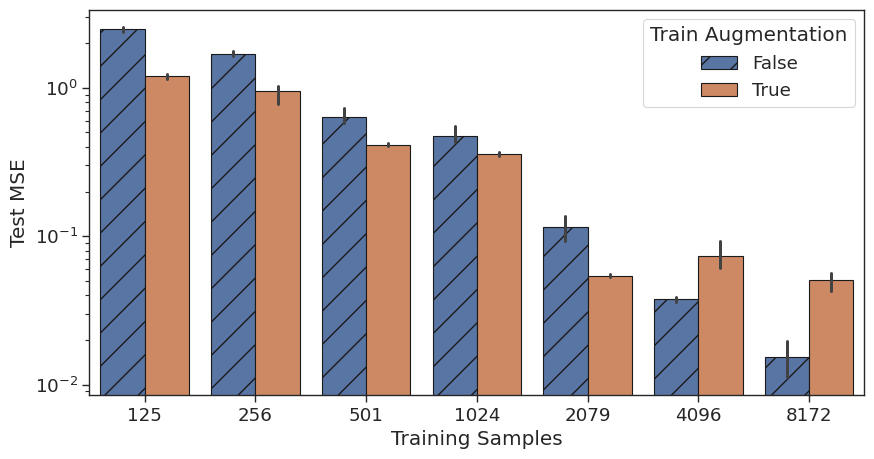

In [13]:
sns.set_theme(context="paper", style="ticks", font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_yscale("log")
# df = pd.read_csv("sample_efficiency_trials.csv")
plot = sns.barplot(data=henon_df, x="num_train", y="loss", hue="Train Augmentation")

fix_barplot_patches(plot)
ax.set_yscale('log')
ax.set_xlabel("Training Samples")
ax.set_ylabel("Test MSE")
ax.legend(title="Train Augmentation", loc='upper right')

plt.savefig("henon_map_bargraph.pdf", bbox_inches="tight")

In [8]:
augmented_models = []
non_augmented_models = []

p = Path(log_dir)
for i in p.rglob('*henon_map_num_samples_12800/'):
    print(i.name)
    if i.is_dir():
        for child in i.rglob("*.ckpt"):
            print(child.name)
            if (child.name.strip(".ckpt").split("_")[-1]) == "True":
                augmented_models.append(LightningResNet18().load_from_checkpoint(child.resolve()))
            else:
                non_augmented_models.append(LightningResNet18().load_from_checkpoint(child.resolve()))


henon_map_num_samples_12800
epoch=92-val_mse=1.44e-02_randomized_False.ckpt


/home/connorsteph/miniconda3/envs/DL_PSI_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch=73-val_mse=1.79e-02_randomized_False.ckpt
epoch=95-val_mse=2.11e-02_randomized_False.ckpt
henon_map_num_samples_12800
epoch=94-val_mse=5.20e-02_randomized_True.ckpt
epoch=94-val_mse=6.05e-02_randomized_True.ckpt
epoch=63-val_mse=5.82e-02_randomized_True.ckpt


In [9]:
traj_lengths = [33, 66, 112, 225, 450, 900]

df_list = []

for t in traj_lengths:
    print(t)
    # --- Augmented ---
    np.random.seed(42)
    torch.manual_seed(42)
    aug_datamodule = HenonMapPoincareDataModule(
                        num_samples=3200,
                        batch_size=32, 
                        a_range=a_range,
                        b_range=b_range,
                        x_range=x_range,
                        y_range=y_range,
                        img_width=img_widths[0],
                        alpha=alpha,
                        min_samples=min_samples,
                        max_samples=max_samples,
                        min_traj_len=t,
                        num_iters=t,
                        num_workers=num_workers,
                        verbose=False,
                        randomize=True)
    # --- Non-Augmented ---
    np.random.seed(42)
    torch.manual_seed(42)
    non_aug_datamodule = HenonMapPoincareDataModule(
                    num_samples=3200,
                    batch_size=32, 
                    a_range=a_range,
                    b_range=b_range,
                    x_range=x_range,
                    y_range=y_range,
                    img_width=img_widths[0],
                    alpha=alpha,
                    min_samples=min_samples,
                    max_samples=max_samples,
                    min_traj_len=t,
                    num_iters=t,
                    num_workers=num_workers,
                    verbose=False,
                    randomize=False)
    
    for augmented_model, non_augmented_model in zip(augmented_models, non_augmented_models):
        aug_aug_loss = trainer.test(model=augmented_model, dataloaders=aug_datamodule, verbose=False)[0]['val_mse']    
        aug_non_loss = trainer.test(model=augmented_model, dataloaders=non_aug_datamodule, verbose=False)[0]['val_mse']
        non_aug_loss = trainer.test(model=non_augmented_model, dataloaders=aug_datamodule, verbose=False)[0]['val_mse']
        non_non_loss = trainer.test(model=non_augmented_model, dataloaders=non_aug_datamodule, verbose=False)[0]['val_mse']
        print(f"{aug_aug_loss=}, {aug_non_loss=}, {non_aug_loss=}, {non_non_loss=}")
        df_list.append({"traj_len": t, "Training Augmentation":True, "Testing Augmentation":True, "Loss":aug_aug_loss})
        df_list.append({"traj_len": t, "Training Augmentation":True, "Testing Augmentation":False, "Loss":aug_non_loss})
        df_list.append({"traj_len": t, "Training Augmentation":False, "Testing Augmentation":True, "Loss":non_aug_loss})
        df_list.append({"traj_len": t, "Training Augmentation":False, "Testing Augmentation":False, "Loss":non_non_loss})

df = pd.DataFrame(df_list)
df.to_csv("henon_map_length_generalization_study.csv")

33


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04626543074846268, aug_non_loss=0.021376315504312515, non_aug_loss=1.5555567741394043, non_non_loss=0.07609906792640686


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.05712556838989258, aug_non_loss=0.029307542368769646, non_aug_loss=1.6663599014282227, non_non_loss=0.04359212517738342


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04924919083714485, aug_non_loss=0.029007304459810257, non_aug_loss=1.8179274797439575, non_non_loss=0.11322325468063354
66


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04458096995949745, aug_non_loss=0.022770432755351067, non_aug_loss=1.403638482093811, non_non_loss=0.03859540820121765


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.05243757367134094, aug_non_loss=0.02712901122868061, non_aug_loss=1.500260829925537, non_non_loss=0.019391758367419243


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04875681921839714, aug_non_loss=0.03151330724358559, non_aug_loss=1.623737096786499, non_non_loss=0.06715045869350433
112


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04437461122870445, aug_non_loss=0.02266952581703663, non_aug_loss=1.3565852642059326, non_non_loss=0.012866790406405926


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.05228192359209061, aug_non_loss=0.026899093762040138, non_aug_loss=1.452595829963684, non_non_loss=0.015138116665184498


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04944011941552162, aug_non_loss=0.0319652296602726, non_aug_loss=1.5340710878372192, non_non_loss=0.021174205467104912
225


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04284130036830902, aug_non_loss=0.02306632697582245, non_aug_loss=1.3153883218765259, non_non_loss=0.011304634623229504


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.0520753487944603, aug_non_loss=0.02699015662074089, non_aug_loss=1.425626277923584, non_non_loss=0.015115623362362385


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.0489766001701355, aug_non_loss=0.032271526753902435, non_aug_loss=1.4891324043273926, non_non_loss=0.01970759406685829
450


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04286612197756767, aug_non_loss=0.022944536060094833, non_aug_loss=1.3126602172851562, non_non_loss=0.011169984936714172


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.05207736790180206, aug_non_loss=0.027010668069124222, non_aug_loss=1.4217782020568848, non_non_loss=0.015070282854139805


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.049211207777261734, aug_non_loss=0.03230055049061775, non_aug_loss=1.4845426082611084, non_non_loss=0.019649986177682877
900


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04286224767565727, aug_non_loss=0.022944509983062744, non_aug_loss=1.3126592636108398, non_non_loss=0.011169997043907642


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.05207240208983421, aug_non_loss=0.027010750025510788, non_aug_loss=1.421790361404419, non_non_loss=0.015070297755300999


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.04921495169401169, aug_non_loss=0.032300591468811035, non_aug_loss=1.4845516681671143, non_non_loss=0.019649984315037727


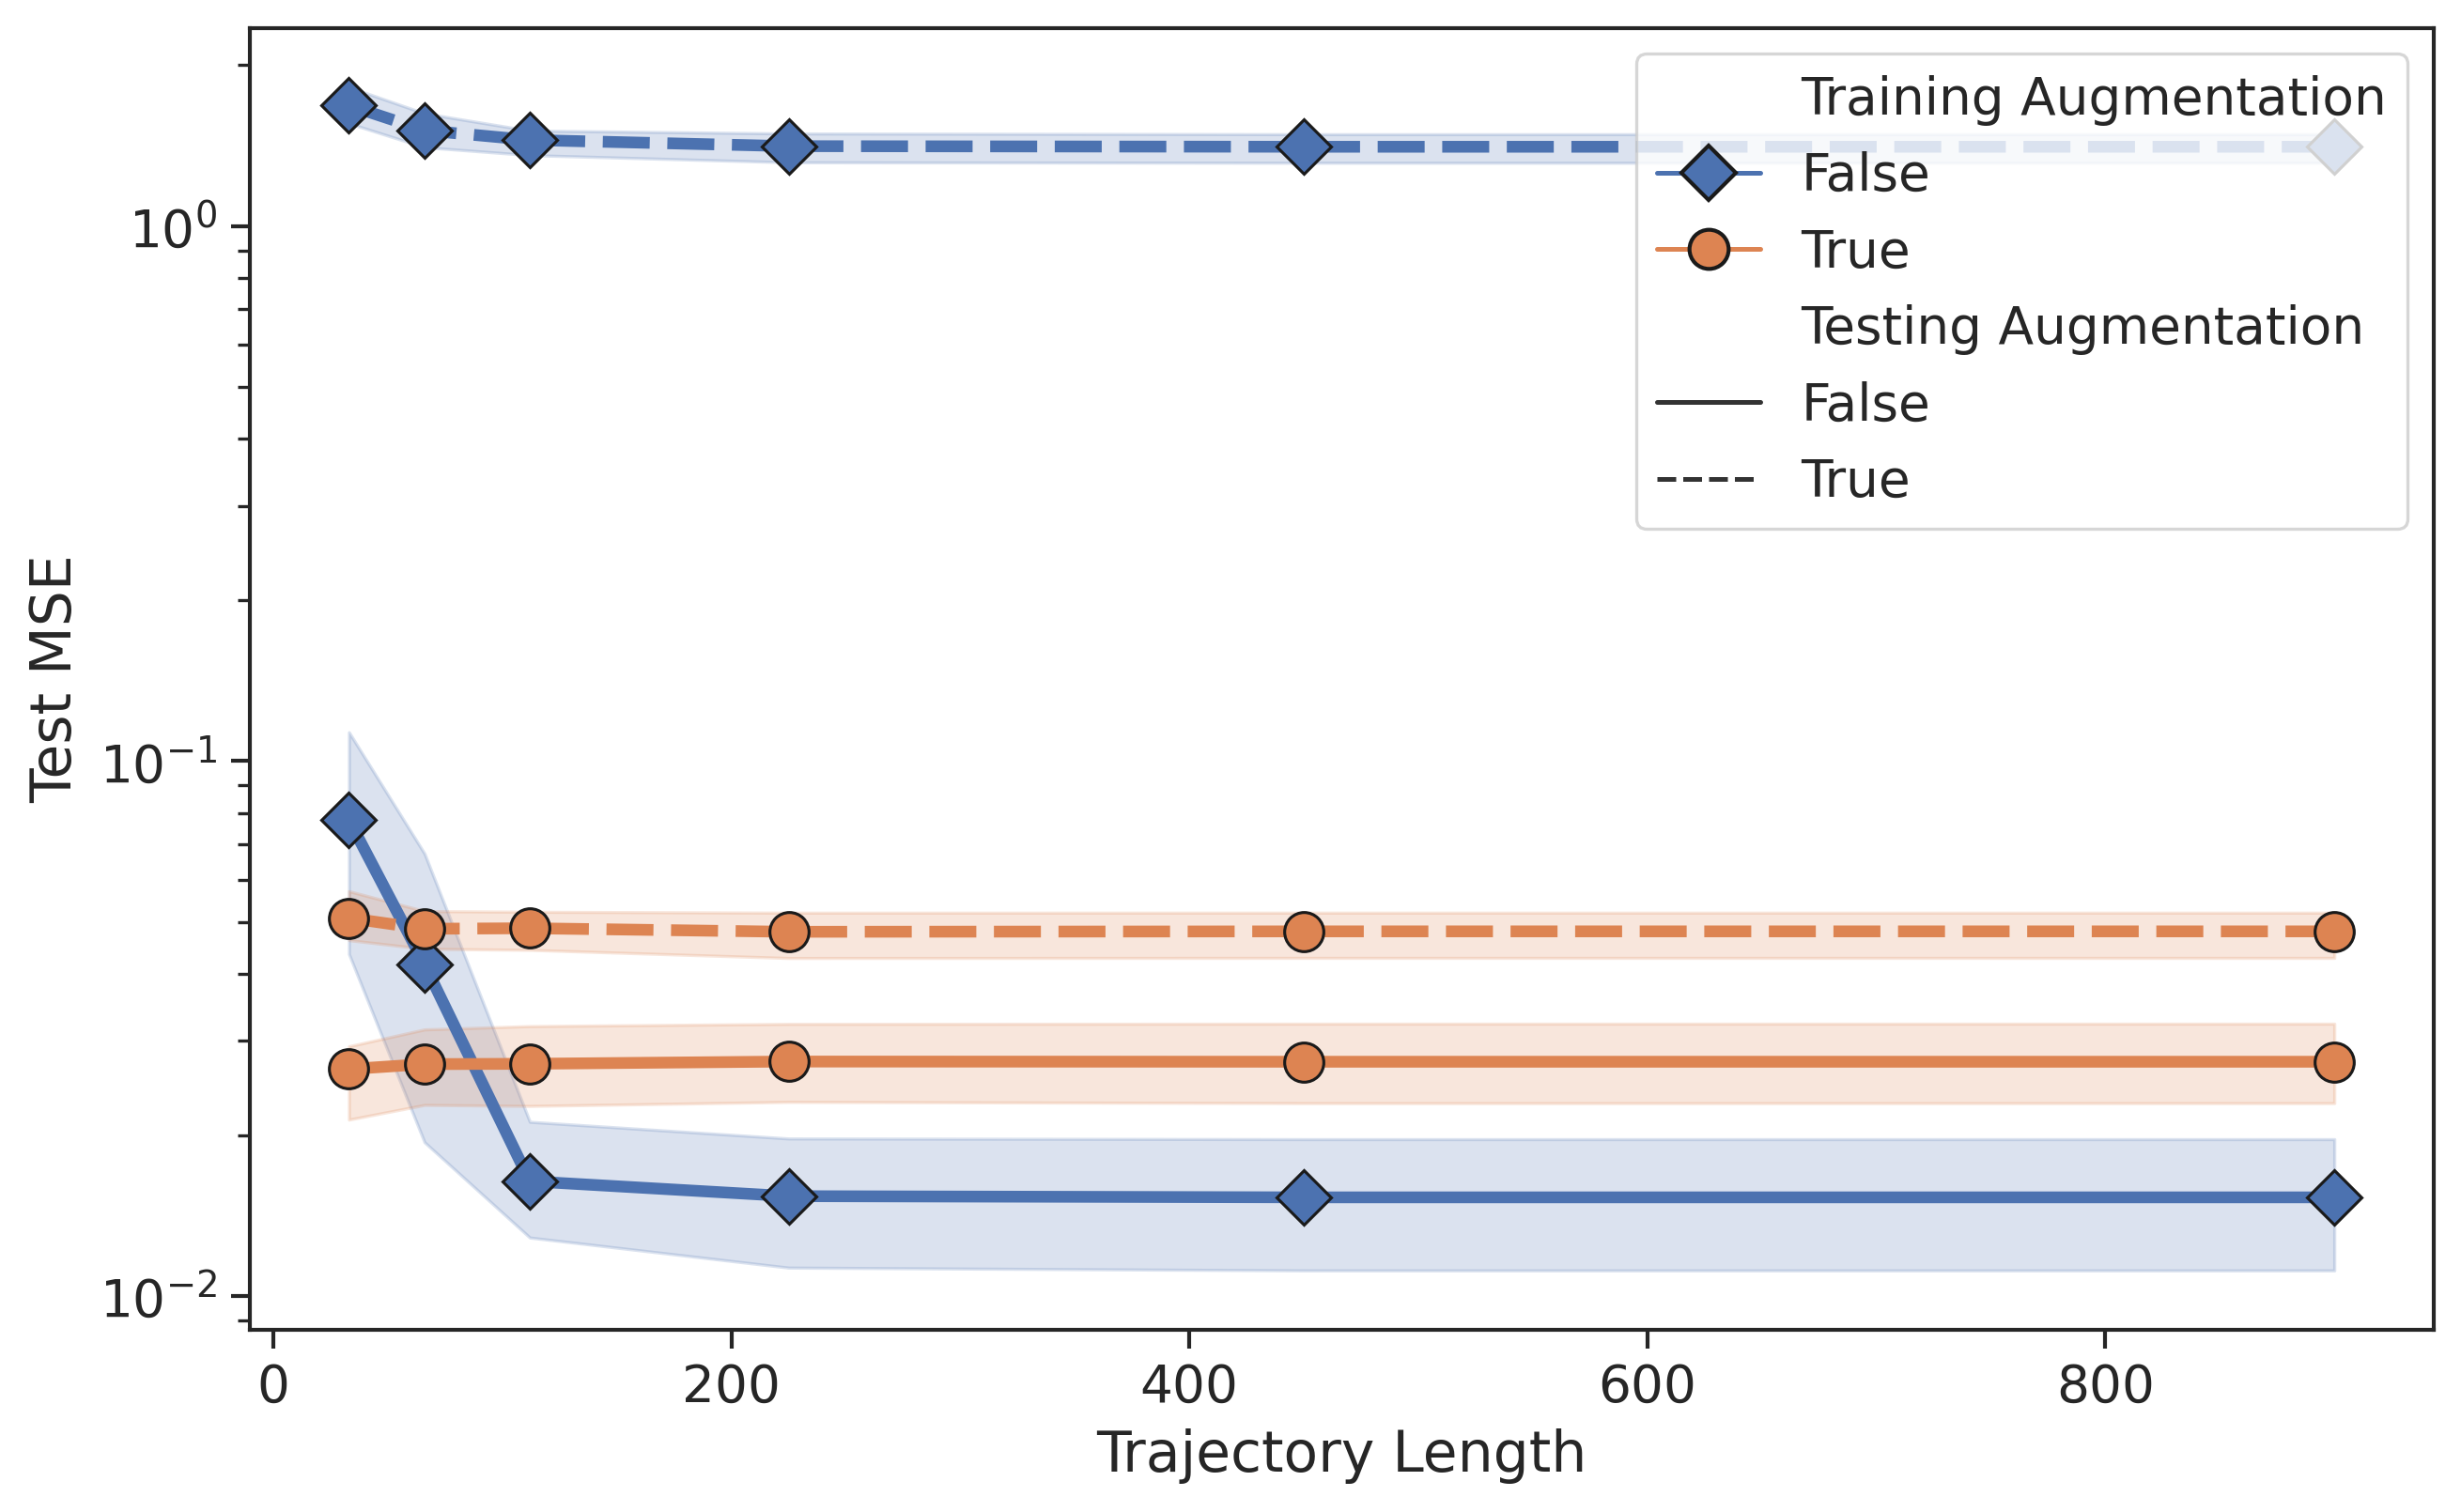

In [11]:
df = pd.read_csv("henon_map_length_generalization_study.csv")

fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=300)
plot = sns.lineplot(data=df, x="traj_len", y="Loss", hue="Training Augmentation", style="Testing Augmentation", ax=ax,
     linewidth=3, markers=True, markeredgecolor='k')
fix_lineplot_markers(plot)
ax.set_yscale('log')
ax.set_xlabel("Trajectory Length")
ax.set_ylabel("Test MSE")
ax.legend(loc='upper right')
fig.savefig("henon_map_trajectory_length_study.pdf", bbox_inches="tight")